## Introduction

Localization is a task that finds an object in an image and localizes the object with a bounding box. Localization is a crucial aspect of image analysis, allowing machine learning model to understand not only what is present in an image but also where it is located.

If you're interested in exploring similar data analysis or learning more about AI applications, then checkout my personal website https://hughiephan.co . Don't forget to upvote if you found the notebook insightful or helpful. Your feedback is valuable and can help others discover useful content.

## Import libraries

In [1]:
import pandas as pd
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, GlobalAveragePooling2D, Activation, Dropout
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split

## Set variables

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
input_shape = (512, 512, 3)
input_size = (512, 512)
np.random.seed(42)
tf.random.set_seed(42)

## Dataset

`load_dataset` function reads a CSV file containing image names and bounding box coordinates, then splits the dataset into training, validation, and test sets. `read_image_bbox` function reads and preprocesses an image, normalizing its pixel values and scaling the bounding box coordinates to normalized values. The `parse` function integrates the image and bounding box processing using TensorFlow operations. `tf_dataset` function creates a TensorFlow dataset from image and bounding box pairs, batching the data and prefetching for improved performance. Finanly the dataset, loaded through the `load_dataset` function, is divided into training, validation, and test sets. TensorFlow datasets `train_ds` and `valid_ds` are then constructed using the `tf_dataset` function

In [3]:
def load_dataset(path, split=0.1):
    images = []
    bboxes = []
    df = pd.read_csv(os.path.join(path, "bbox.csv"))
    for index, row in df.iterrows():
        name = row["name"]
        x1 = int(row["x1"])
        y1 = int(row["y1"])
        x2 = int(row["x2"])
        y2 = int(row["y2"])
        image = os.path.join(path, "images", name)
        bbox = [x1, y1, x2, y2]
        images.append(image)
        bboxes.append(bbox)
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(bboxes, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image_bbox(path, bbox):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = image.shape
    image = cv2.resize(image, input_size)
    image = (image - 127.5) / 127.5 # Normalize into [-1, +1]
    image = image.astype(np.float32)
    x1, y1, x2, y2 = bbox
    norm_x1 = float(x1/w)
    norm_y1 = float(y1/h)
    norm_x2 = float(x2/w)
    norm_y2 = float(y2/h)
    norm_bbox = np.array([norm_x1, norm_y1, norm_x2, norm_y2], dtype=np.float32)
    return image, norm_bbox

def parse(x, y):
    x, y = tf.numpy_function(read_image_bbox, [x, y], [tf.float32, tf.float32])
    x.set_shape(input_shape)
    y.set_shape([4])
    return x, y
 
def tf_dataset(images, bboxes, batch=8):
    ds = tf.data.Dataset.from_tensor_slices((images, bboxes))
    ds = ds.map(parse).batch(batch).prefetch(10)
    return ds

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset("/kaggle/input/human-detection")
train_ds = tf_dataset(train_x, train_y, batch=16)
valid_ds = tf_dataset(valid_x, valid_y, batch=16)

## Intersection Over Union (IOU Metrics)

`cal_iou` function calculates the Intersection over Union `IoU` metric, which quantifies the overlap between predicted and true bounding boxes.

![image.png](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

In [4]:
def cal_iou(y_true, y_pred):
    x1 = max(y_true[0], y_pred[0])
    y1 = max(y_true[1], y_pred[1])
    x2 = min(y_true[2], y_pred[2])
    y2 = min(y_true[3], y_pred[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
    bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)
    iou = intersection_area / float(true_area + bbox_area - intersection_area)
    return iou

## Model

Our model architecture is based on MobileNetV2, pre-trained on ImageNet, with modifications to the final layer for bounding box prediction. The MobileNetV2 backbone is frozen `trainable=False`, and additional layers are appended, including a 1x1 convolutional layer, batch normalization, global average pooling, dropout, and a dense layer for output. The model is compiled using binary cross-entropy loss and the Adam optimizer. Training occurs over 2 epochs using the training dataset `train_ds`, with validation on the validation dataset `valid_ds`. 

In [5]:
inputs = Input(input_shape)
backbone = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    alpha=1.0
)
backbone.trainable = False
output = Conv2D(256, kernel_size=1, padding="same")(backbone.output)
output = BatchNormalization()(output)
output = Activation("relu")(output)
output = GlobalAveragePooling2D()(output)
output = Dropout(0.5)(output)
output = Dense(4, activation="sigmoid")(output)
model = Model(inputs, output)
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
)
model.fit(
    train_ds,
    epochs=2,
    validation_data=valid_ds,
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/2
43/43 [==============================] - 147s 3s/step - loss: 0.5383 - val_loss: 0.4652
Epoch 2/2
43/43 [==============================] - 140s 3s/step - loss: 0.4571 - val_loss: 0.4639


## Predict and visualize

We will evaluate our localization model on a single test image. The image and its true bounding box are selected, and the model is used to predict a bounding box. Both the ground truth and predicted bounding boxes are visualized on the image, with the IOU. 

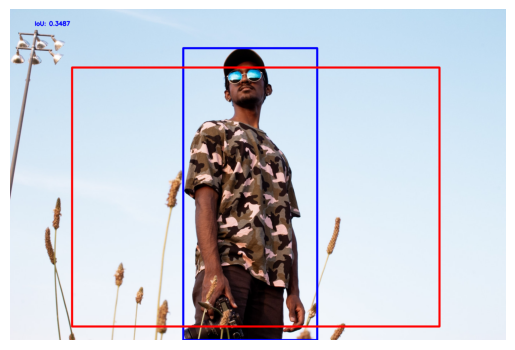

In [6]:
# Predict
image, true_bbox = test_x[3], test_y[3] # Pick an image from Test set
image = cv2.imread(image, cv2.IMREAD_COLOR) 
true_x1, true_y1, true_x2, true_y2 = true_bbox 
image_resize = cv2.resize(image, input_size)
image_resize = np.expand_dims(image_resize, axis=0)
output = model(image_resize)
pred_bbox = output.numpy()[0]

# Visualize
pred_x1 = int(pred_bbox[0] * image.shape[1])
pred_y1 = int(pred_bbox[1] * image.shape[0])
pred_x2 = int(pred_bbox[2] * image.shape[1])
pred_y2 = int(pred_bbox[3] * image.shape[0])
image = cv2.rectangle(image, (true_x1, true_y1), (true_x2, true_y2), (255, 0, 0), 10) ## BLUE
image = cv2.rectangle(image, (pred_x1, pred_y1), (pred_x2, pred_y2), (0, 0, 255), 10) ## RED
x = cv2.resize(image, input_size)
x = (x - 127.5) / 127.5
x = np.expand_dims(x, axis=0)
x = int(image.shape[1] * 0.05)
y = int(image.shape[0] * 0.05)
font_size = int(image.shape[0] * 0.001)
iou = cal_iou(true_bbox, [pred_x1, pred_y1, pred_x2, pred_y2])
cv2.putText(image, f"IoU: {iou:.4f}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), 3)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()